In [1]:
import pandas as pd
import numpy as np

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    average_precision_score, ConfusionMatrixDisplay, RocCurveDisplay
)
import matplotlib.pyplot as plt
target_names = ['Not taking Contract', 'Takes Contract']



In [2]:
data = pd.read_csv('data/wallacecommunications.csv', delimiter=',')
# drop the month value with 'j' as it can be January, June, July
data = data[data['last_contact_this_campaign_month'] != 'j']
# drop ID as it is just identifier and Country
data = data.drop(columns= ['ID', 'country','last_contact_this_campaign_day','conn_tr','town', 
                           'married'])
# Replace the incorrect values to correct value
data['has_tv_package'] = data['has_tv_package'].replace({'n':'no'})
data['last_contact'] = data['last_contact'].replace({'cell':'cellular'})


In [ ]:
#List of binary columns
binary_cols = ['arrears', 'housing', 'has_tv_package']
for cols in binary_cols:
    data[cols] = data[cols].map({'yes':1, 'no':0})

In [ ]:
#calculate new feature for separation
data['never_contacted'] = (data['days_since_last_contact_previous_campaign'] == -1).astype(int)
data['days_since_last_contact_previous_campaign'] = (
    data['days_since_last_contact_previous_campaign'].replace(-1, np.nan)
)

In [5]:
categorical_features = ['job','education', 'last_contact', 'never_contacted',
                         'last_contact_this_campaign_month', 'outcome_previous_campaign']
numerical_features = ['age', 'current_balance', 'this_campaign', 'days_since_last_contact_previous_campaign', 
                      'contacted_during_previous_campaign']
print(len(categorical_features), len(numerical_features))


6 5


In [6]:
X = data.drop(columns=['new_contract_this_campaign'])
y = data['new_contract_this_campaign'].map({"yes": 1, "no": 0})

In [7]:
numeric_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='constant', fill_value=999999)),
    ("scaler", StandardScaler())
])

In [8]:
data_processor = ColumnTransformer(
        transformers=[
            ('num', numeric_preprocess, numerical_features),
            ('cat', OneHotEncoder(drop='first'), categorical_features)
        ],
        remainder='passthrough'
    )

In [9]:
X_85, X_test, y_85, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_85, y_85, test_size=0.1765, random_state=42, stratify=y_85
)

In [10]:
mlp_pl= Pipeline([
        ('preprocessor', data_processor),
        ('classifier', MLPClassifier(random_state=42, max_iter=1500))
    ])

In [11]:
mlp_pl.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [12]:
y_pred_ml = mlp_pl.predict(X_val)
y_proba_ml = mlp_pl.predict_proba(X_val)[:,1]

MLP  —  Acc: 0.844 | AUC: 0.811


<Figure size 640x480 with 0 Axes>

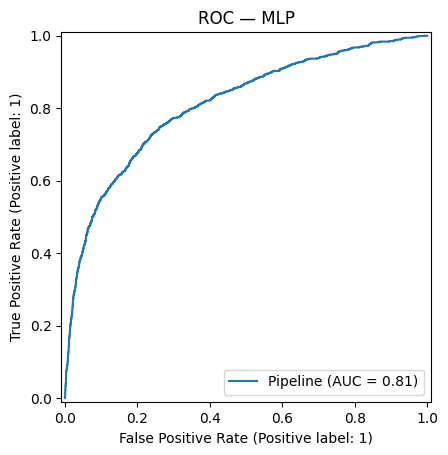

<Figure size 640x480 with 0 Axes>

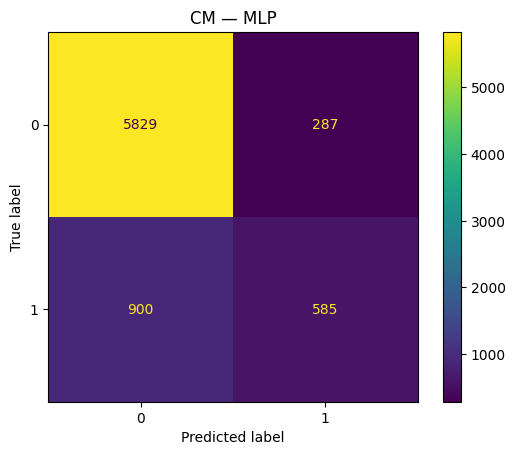


===== BASELINE MODEL ON VALIDATION =====
Accuracy: 0.8438363373240363
Precision (YES): 0.6708715596330275
Recall (YES): 0.3939393939393939
F1-score: 0.4963937208315656
ROC AUC: 0.8105324555782372
PR AUC: 0.5637304432561481

Confusion Matrix:
 [[5829  287]
 [ 900  585]]

Classification Report:
                      precision    recall  f1-score   support

Not taking Contract       0.87      0.95      0.91      6116
     Takes Contract       0.67      0.39      0.50      1485

           accuracy                           0.84      7601
          macro avg       0.77      0.67      0.70      7601
       weighted avg       0.83      0.84      0.83      7601



In [13]:
print(f"MLP  —  Acc: {accuracy_score(y_val, y_pred_ml):.3f} | AUC: {roc_auc_score(y_val, y_proba_ml):.3f}")
fig = plt.figure(); RocCurveDisplay.from_estimator(mlp_pl, X_val, y_val); plt.title("ROC — MLP"); plt.show()
fig = plt.figure(); ConfusionMatrixDisplay.from_predictions(y_val, y_pred_ml); plt.title("CM — MLP"); plt.show()

print("\n===== BASELINE MODEL ON VALIDATION =====")
print("Accuracy:", accuracy_score(y_val, y_pred_ml))
print("Precision (YES):", precision_score(y_val, y_pred_ml, pos_label=1))
print("Recall (YES):", recall_score(y_val, y_pred_ml, pos_label=1))
print("F1-score:", f1_score(y_val, y_pred_ml, pos_label=1))
print("ROC AUC:", roc_auc_score(y_val, y_proba_ml))
print("PR AUC:", average_precision_score(y_val, y_proba_ml))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred_ml))
print("\nClassification Report:\n", classification_report(y_val, y_pred_ml, target_names=target_names))

In [14]:
param_grid =  {
        'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'classifier__activation': ['tanh', 'relu'],
        'classifier__alpha': [1e-4, 5e-4, 1e-3, 5e-3],
        'classifier__learning_rate_init': [0.001, 0.01]
    }

In [ ]:


random_search = GridSearchCV(
            estimator=mlp_pl, 
            param_grid=param_grid, 
            cv=StratifiedKFold(n_splits=3, shuffle=True), 
            scoring='f1', 
            verbose=1, 
            n_jobs=-1
        )

In [16]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'classifier__activation': ['tanh', 'relu'], 'classifier__alpha': [0.0001, 0.0005, ...], 'classifier__hidden_layer_sizes': [(50,), (100,), ...], 'classifier__learning_rate_init': [0.001, 0.01]}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo...shuffle=False)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [17]:
best_model = random_search.best_estimator_
best_model.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('num',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(fill_value=999999,
                                                                   strategy='constant')),
                                                    ('scaler', StandardScaler())]),
                                    ['age', 'current_balance', 'this_campaign',
                                     'days_since_last_contact_previous_campaign',
                                     'contacted_during_previous_campaign']),
                                   ('cat', OneHotEncoder(drop='first'),
                                    ['job', 'education', 'last_contact',
                                     'never_contacted',
                                     'last_contact_this_campaign_month',
                             

In [18]:
y_pred_th = best_model.predict(X_val)
y_proba_th = best_model.predict_proba(X_val)[:,1]

MLP  —  Acc: 0.867 | AUC: 0.861


<Figure size 640x480 with 0 Axes>

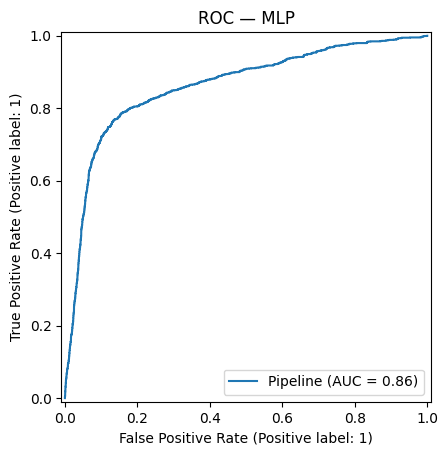

<Figure size 640x480 with 0 Axes>

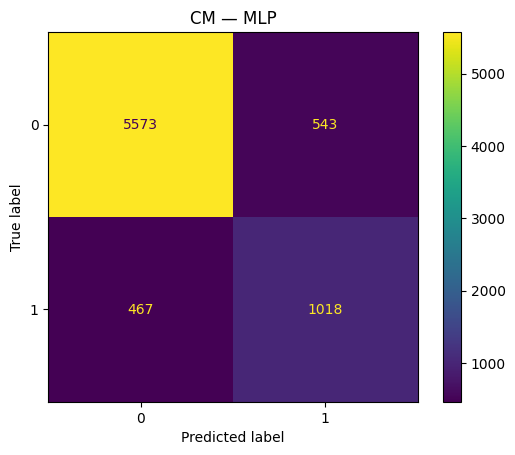


===== HYPERTUNED MODEL ON VALIDATION =====
Accuracy: 0.8671227470069728
Precision (YES): 0.6521460602178091
Recall (YES): 0.6855218855218855
F1-score: 0.6684175968483257
ROC AUC: 0.8608171864712086
PR AUC: 0.6231764777227561

Confusion Matrix:
 [[5573  543]
 [ 467 1018]]

Classification Report:
                      precision    recall  f1-score   support

Not taking Contract       0.92      0.91      0.92      6116
     Takes Contract       0.65      0.69      0.67      1485

           accuracy                           0.87      7601
          macro avg       0.79      0.80      0.79      7601
       weighted avg       0.87      0.87      0.87      7601



In [19]:
print(f"MLP  —  Acc: {accuracy_score(y_val, y_pred_th):.3f} | AUC: {roc_auc_score(y_val, y_proba_th):.3f}")
fig = plt.figure(); RocCurveDisplay.from_estimator(best_model, X_val, y_val); plt.title("ROC — MLP"); plt.show()
fig = plt.figure(); ConfusionMatrixDisplay.from_predictions(y_val, y_pred_th); plt.title("CM — MLP"); plt.show()

print("\n===== HYPERTUNED MODEL ON VALIDATION =====")
print("Accuracy:", accuracy_score(y_val, y_pred_th))
print("Precision (YES):", precision_score(y_val, y_pred_th, pos_label=1))
print("Recall (YES):", recall_score(y_val, y_pred_th, pos_label=1))
print("F1-score:", f1_score(y_val, y_pred_th, pos_label=1))
print("ROC AUC:", roc_auc_score(y_val, y_proba_th))
print("PR AUC:", average_precision_score(y_val, y_proba_th))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred_th))
print("\nClassification Report:\n", classification_report(y_val, y_pred_th, target_names=target_names))

In [26]:
X_final = pd.concat([X_train, X_val])
y_final = pd.concat([y_train, y_val])

In [27]:
best_model.fit(X_final, y_final)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [28]:
y_pred_rf = best_model.predict(X_test)
y_proba_rf = best_model.predict_proba(X_test)[:,1]

MLP  —  Acc: 0.874 | AUC: 0.884


<Figure size 640x480 with 0 Axes>

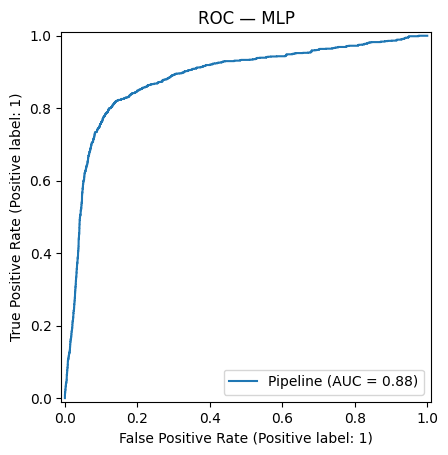

<Figure size 640x480 with 0 Axes>

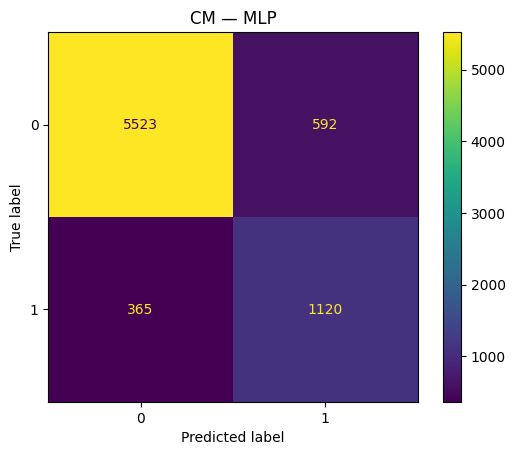


===== HYPERMARAMETERISED MODEL ON TEST =====
Accuracy: 0.8740789473684211
Precision (YES): 0.6542056074766355
Recall (YES): 0.7542087542087542
F1-score: 0.7006568658116985
ROC AUC: 0.8838446057742869
PR AUC: 0.6566704424728732

Confusion Matrix:
 [[5523  592]
 [ 365 1120]]

Classification Report:
                      precision    recall  f1-score   support

Not taking Contract       0.94      0.90      0.92      6115
     Takes Contract       0.65      0.75      0.70      1485

           accuracy                           0.87      7600
          macro avg       0.80      0.83      0.81      7600
       weighted avg       0.88      0.87      0.88      7600



In [35]:
print(f"MLP  —  Acc: {accuracy_score(y_test, y_pred_rf):.3f} | AUC: {roc_auc_score(y_test, y_proba_rf):.3f}")
fig = plt.figure(); RocCurveDisplay.from_estimator(best_model, X_test, y_test); plt.title("ROC — MLP"); plt.show()
fig = plt.figure(); ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf); plt.title("CM — MLP"); plt.show()

print("\n===== HYPERMARAMETERISED MODEL ON TEST =====")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision (YES):", precision_score(y_test, y_pred_rf, pos_label=1))
print("Recall (YES):", recall_score(y_test, y_pred_rf, pos_label=1))
print("F1-score:", f1_score(y_test, y_pred_rf, pos_label=1))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))
print("PR AUC:", average_precision_score(y_test, y_proba_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf, target_names=target_names))